# Northwind Database Project

Name: Hazel Donaldson <br>
Due Date: 8/29/2019 <br>

# Project Overview:

In this project, we will be exploring data provided to us by our client, Northwind, containing sales data for a range of different products. Our goal is to provide the company with several business recommendations through statistically analysis and hypothesis testing.

## 1. Obtain Data/Import Libraries

In [1]:
#import libraries here
import sqlite3
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.power import TTestIndPower, TTestPower
from collections import Counter
import itertools
import warnings
warnings.filterwarnings('ignore')
import scipy as sp

In [2]:
#define functions

#population mean
def calculate_mu(x):
    mu = float(sum(x.values)/len(x))
    return mu
# Create tables from database
def get_column_info(table):
    cols_list = inspector.get_columns(table)
    print('')
    print('-----------------------------------------------------------------------')
    print(f'Table Name: {table}, Primary Key: {inspector.get_primary_keys(table)}')
    print('------------------------------------------------------------------------')
    print('')
    for column in cols_list:
         print(f"Column Name: {column['name']}, Column Type: {column['type']}")

#Cohen's d for effect size
def cohen_d(group1, group2):
               
    diff = group1.mean() - group2.mean()
    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()
    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    return abs(d)
#Generate ANOVA tables
def ANOVA_test(df):
            formula = 'Quantity ~ C(Discount)'
            lm = ols(formula, df).fit()
            table = sm.stats.anova_lm(lm, typ = 2)
            print(table)
#Distribution plot visualization
def dist_visual(control, experimental):
               plt.figure(figsize(10,6))
               sns.distplot(experimental, bins = 50, label = 'Experimental')
               sns.distplot(control, bins = 50, label = 'Control')
               plt.axvline(x.control.mean(), color = 'k', linestyle = '--')
               plt.axvline(x.experimental.mean(), color = 'k', linestyle = '--')
               plt.title("Control and Experimental Sampling Distributions", fontsize = 14)
               plt.xlabel('Distributions')
               plt.ylabel('Frequency')
               plt.legend()
               plt.show()
#comparing average as discount boolean
def print_results(a,b):
    print(f"Average with discount: {round(a,2)}")
    print(f"Average without discount: {round(b, 2)}")
    print(f"Effect Size: {round((a-b), 2)}")
    print(f"Relative Effect Size: {round((a-b)/b, 2)}")
def results_printer_disc(a, b):
    print(f'Avg at current discount level: {round(a, 2)}')
    print(f'Effect Size: {round((a-b),2)}')
    print(f'Relative effect size: {round((a-b)/b,2)}')
    
# Calculate variance ratio for 2 samples:    
def variance_ratio(a,b):
    return np.var(a)/np.var(b)

### Connecting Database

In [16]:
#connect to database
conn = sqlite3.connect('Northwind_small.sqlite')
c = conn.cursor()

In [ ]:
c.execute("""SELECT name from sqlite_master WHERE type = 'table';""")
tables = c.fetchall()
tables = [i[0] for i in tables]

In [ ]:
#loop list of data into pandas dataframe
dfs = []
for i in tables:
    table = c.execute('select * from "'+ i +'"').fetchall()
    columns = c.execute('PRAGMA table_info("'+ i +'")').fetchall()
    df = pd.DataFrame(table, columns = [i[1] for i in columns])
    foo = i +'_df' #TableName_df
    exec(foo + "=df")
    dfs.append(foo) #a list of all the tables

In [ ]:
dfs

In [ ]:
#alternative
engine = create_engine('sqlite:///Northwind_small.sqlite', echo = True)
Session = sessionmaker(bind=engine)
session = Session()

In [ ]:
from sqlalchemy import inspect
inspector = inspect(engine)

print(inspector.get_table_names())

In [ ]:
tables = inspector.get_table_names()
for table in tables:
    print(get_column_info(table))

In [ ]:
#list of all tables
cur.execute('''SELECT Quantity, Discount FROM OrderDetail ORDER BY Quantity DESC;''')
df = pd.DataFrame(cur.fetchall())
df.columns = [column[0] for column in cur.description]
df.head()

In [ ]:
#Converting the database tables into Pandas dataframes
df_Category = pd.read_sql_query("SELECT * FROM Category", engine)
df_Customer = pd.read_sql_query("SELECT * FROM Customer", engine)
df_CustomerDemographic = pd.read_sql_query("SELECT * FROM CustomerDemographic", engine)
df_Employee = pd.read_sql_query("SELECT * FROM Employee", engine)
df_EmployeeTerritory = pd.read_sql_query("SELECT * FROM EmployeeTerritory", engine)
df_order = pd.read_sql_query("SELECT * FROM 'Order'", engine)
df_Product = pd.read_sql_query("SELECT * FROM Product", engine)
df_region = pd.read_sql_query("SELECT * FROM Region", engine)
df_Supplier = pd.read_sql_query("SELECT * FROM Supplier", engine)
df_Territory = pd.read_sql_query("SELECT * FROM Territory", engine)
df_OrderDetail = pd.read_sql_query("SELECT * FROM OrderDetail", engine)
df_Shipper = pd.read_sql_query("SELECT * FROM Shipper", engine)
df_customercustomerdemo = pd.read_sql_query("SELECT * FROM CustomerCustomerDemo", engine)

## Add screenshot of schema

Below is an overview of the Northwind schema. Here I will do light exploration to familarize myself with the different tables that would of interest to us.


https://raw.githubusercontent.com/learn-co-students/dsc-mod-3-project-online-ds-pt-041519/master/Northwind_ERD_updated.png

### Category Table:

In [ ]:
c.execute("""SELECT * FROM Category""").fetchall()

Based on this exploration, it looks like Nortwind is a food and beverage distribution. I may explore which categrory is doing the best in terms of sales. Now, we should get a better picture of the the products sold by Northwind.

## Product Table

In [ ]:
c.execute("""SELECT * FROM Product""").fetchall()

As we can see above, Northwind distributed 77 products, some of which are discontinued. For now, I will ignore the presence of the discontinued products but include them in the analysis. If it is found that those products have a positive effect on sales, I will recommend that those products be restocked.

## Customer Table

In [ ]:
c.execute("""SELECT * FROM Customer""")
customer = pd.DataFrame(c.fetchall())
customer.columns = [column[0] for column in c.description]
customer.head(3)

In [ ]:
print(customer.info())

In [ ]:
#Indentifying the names of Northwind's customers:
customer.CompanyName.unique()

In [ ]:
customer_demo = customer.groupby(['Region'])['CompanyName'].count()
customer_demo

In [ ]:
customer_country = customer.groupby(['Country'])['CompanyName'].count()
customer_country

Based on customer demographics, Northwind operates internationally with customers in 21 different countries. The USA, France, Germany and the UK being their biggest customers with 13, 11, 11, and 7 respectively. Regionally, Western Europe and North America are their biggest customers with 28 and 16 respectively. 

## Employee Table:

In [ ]:
c.execute("""SELECT * FROM Employee""").fetchall()

Northwind had a total of nine employees who work mainly in the USA and offices in Seattle and London areas. In our EDA, we may choose to compare sales between the Seattle and London offices.

## Order, Order Detail Table

In [ ]:
c.execute('''SELECT * FROM [Order]''')
orders = pd.DataFrame(c.fetchall())
orders.columns = [column[0] for column in c.description]
orders.head()

In [ ]:
print(df_order.info())

In [ ]:
orders.ShipRegion.unique()

In [ ]:
c.execute('''SELECT * FROM [OrderDetail]''')
orderdetails = pd.DataFrame(c.fetchall())
orderdetails.columns = [column[0] for column in c.description]
orderdetails.head(3)

In [ ]:
orderdetails.info()

## Shipper, Supplier table

In [ ]:
c.execute("""SELECT * FROM Shipper""").fetchall()

In [ ]:
c.execute("""SELECT * FROM Supplier""").fetchall()

## Question # 1

##  Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?

This question needs to be split into two different tests.
Usually, discounts increases order quantity, so it would be reasonable to perform one-tailed test with an alpha set at 0.025. If p < alpha, we can reject the null hypothesis.

### Part a:

$H_0$: Discounts have no effect on the number of products customers order <br>
$H_a$: Discounts have an effect on the number of products customers order <br>
$alpha$ : 0.025

In [ ]:
c.execute("""SELECT ProductId, UnitPrice, Quantity, Discount FROM OrderDetail""")
discounts = pd.DataFrame(c.fetchall())
discounts.columns = [column[0] for column in c.description]
discounts.head()

In [ ]:
discounts.info()

In [ ]:
#looking for the presence of a discount
discounts['DiscBool'] = discounts['Discount'].apply(lambda x: 0 if x == 0 else 1)
discounts.head()

In [ ]:
discounts.Discount.value_counts()

As we can see above, the number of orders for non-discounted items is low but the average order size is larger than the discounted items. In order to determine the size of the effect, we will test whether this difference is statistically significant.

In [ ]:
discounts = discounts[discounts.Discount.isin([0.00, 0.05, 0.10, 0.15, 0.20, 0.25])] 
discounts.head()

In [ ]:
# Comparing the Number of Orders and Average Order Size to DisBool
fig, axes = plt.subplots(2, 1, figsize = (12, 5))
sns.set_style('whitegrid')

#Grouping DataFrame for visualization
discounts.groupby(['DiscBool'])['Quantity'].count().plot(kind = 'barh', ax = axes[0], color = ['#a0b0f0', '#c9f9a0'])
discounts.groupby(['DiscBool'])['Quantity'].mean().plot(kind = 'barh', ax = axes[1], color = ['#a0b0f0', '#c9f9a0'])
# First plot labels
axes[0].set_title('Number of Orders', fontsize = 13)
axes[0].set_xlabel('Orders')
axes[0].set_ylabel('')
axes[0].set_yticklabels(['No Discount', 'Discount'])
#Second plot labels
axes[1].set_title('Average Order Size', fontsize = 13)
axes[1].set_xlabel('Order Size')
axes[1].set_ylabel('')
axes[1].set_yticklabels(['No Discount', 'Discount'])
fig.subplots_adjust(hspace = .75)
fig.savefig('orders_numandsize.png', bbox_inches = 'tight')
plt.show()

In [ ]:
print(f"There are {discounts.groupby(['DiscBool'])['Quantity'].count()[0]-discounts.groupby(['DiscBool'])['Quantity'].count()[1]} more orders made where there is no discount.")
print(f"The average order size for discounted items was {discounts.groupby(['DiscBool'])['Quantity'].mean()[1]-discounts.groupby(['DiscBool'])['Quantity'].mean()[0]} items greater than the order size when there was no discount")

As we can see, the discounted products have a higher number of orders while non discounted items have a larger order size. We shall investigate if these differences are statistically significant.

In [ ]:
# Separating dataframe between discounted and non-discounted order quantities:
control = discounts[discounts['Discount']== 0]['Quantity']
experimental = discounts[discounts['Discount'] != 0]['Quantity']

In [ ]:
query = 'DiscBool != 0'
discounted = discounts.query(query)
discounted.head(3)

In [ ]:
sns.set(rc={'figure.figsize':(10, 5)})
sns.set_style('whitegrid')

ax = sns.distplot(experimental, label = 'Discount')
ax = sns.distplot(control, label = 'No Discount')
#ax = sns.kdeplot(gen_discount, label = 'Discount KDE')
#ax = sns.kdeplot(gen_nodiscount, label = 'No Discount KDE')
ax.set_xlim(-15, 145)
ax.set_title('Distribution of Order Size', fontsize = 13)
ax.legend()

The KDE plot shows us the while there is some postive skew present in the Order distribution size. However because of the sample size we can assume that the distribution is normal.
Because our variables are independent, distributed normally and don't show homogeneity in variance, we will use the Welch's t-test to test test our hypothesis.

In statistics, the Welch's test is a two sample location test that is used to test the hypothesis that the two populations have equal means. 
At first, I created 2 distributions: a control distribution and an experimental distribution. The control distribution includes order quantities without any discounts and the experimental distribution includes order quantities with discounts at any level.

In [ ]:
a = experimental.mean()
b = control.mean()
print_results(a,b)

In [ ]:
#Welch's t-test and cohen's d
print(stats.ttest_ind(experimental, control))
d = cohen_d(experimental, control)
print(d)

As we can see above, we have a p-value < 0.05 which means there is a statistical significance between number of orders between discounted and non discounted items. Therefore we can reject the null hypothesis. The cohen's d value is around 0.3, which is a medium effect.
Because there is a significance between discounted and non discounted items, we can investigate which discount level has the highest significance.

### Part b:

$H_0$ : The average number of orders is the same regardless of discount level <br>
$H_a$ : The average number of orders is not the same the level of discount changes <br>
$alpha$ : 0.05

In [ ]:
#Viewing difference between discount levels against number of orders and average order size visually
#fig, axes = plt.subplot(1, 2, figsize = (12,5))
fig, axes = plt.subplots(2, 1, figsize=(12,5))
sns.set_style('whitegrid')
#Grouping dataframe
discounts.groupby(['Discount'])['Quantity'].count().plot(kind = 'barh', ax = axes[0], color=['#E78AC3', '#A6D854', '#FFD92F', '#E5C494', '#B3B3B3', '#66C2A5'])
discounts.groupby(['Discount'])['Quantity'].mean().plot(kind = 'barh', ax = axes[1], color=['#E78AC3', '#A6D854', '#FFD92F', '#E5C494', '#B3B3B3', '#66C2A5'])
#Plot 1 labels
axes[0].set_title('Number of Orders per Discount Level', fontweight = 'bold', fontsize = 13)
axes[0].set_xlabel('Order Size', fontweight = 'semibold')
axes[0].set_ylabel('')
axes[0].set_yticklabels(['No Discount', '0.05', '0.10', '0.15', '0.20', '0.25'])

#Plot 2 labels
axes[1].set_title('Average Order Size by Discount Level', fontweight = 'bold', fontsize = 13)
axes[1].set_xlabel('Average Order Size', fontweight = 'semibold')
axes[1].set_ylabel('')
axes[1].set_yticklabels(['No Discount', '0.05', '0.10', '0.15', '0.20', '0.25'])
fig.subplots_adjust(hspace = .75);
fig.savefig('discountlevels.png', bbox_inches = 'tight')

In contrast to the first part, we observe a smaller difference in average order size between all the discount levels and a larger difference in the number of order sizes.

In [ ]:
#fitting using statsmodels ols
lm = ols('Quantity ~ C(Discount)', discounted).fit()
lm.summary()

In [ ]:
#ANOVA analysis to test multiple comparisons test
sm.stats.anova_lm(lm, typ = 2)

We fail to reject the null hypothesis as the p-value is greater than 0.05. Turning each discount level into a dataframe for the Tukey test.

In [ ]:
disc_bool_05 = discounted[discounted.Discount.isin([0.05])]
disc_bool_10 = discounted[discounted.Discount.isin([0.10])]
disc_bool_15 = discounted[discounted.Discount.isin([0.15])]
disc_bool_20 = discounted[discounted.Discount.isin([0.20])]
disc_bool_25 = discounted[discounted.Discount.isin([0.25])]
disc_bool_05.head() #sanity check

In [ ]:
#Prepping for tukey test:
values = [0.00, 0.05, 0.10, 0.15, 0.20, 0.25]
discount_tukey = discounts[discounts.Discount.isin(values)]
discount_tukey.head()

In [ ]:
#Tukey test
tk = pairwise_tukeyhsd(discount_tukey.Quantity, discount_tukey.Discount, .05)
print(tk)

Reviewing the Tukey test, we fail to reject the null hypothesis for the non-discounted items (control) and 0.10 discounted items (experimental) items. However, we reject the null hypothesis for non-discounted items and discounted items at 0.05, 0.15, 0.20 and 0.25. 
There is no statistically significant difference between the number of products ordered between the non-zero discounted level.

So, in summary there is a statistically significant difference in order quantity based on the presence of a discount at any level, but there is no statistically significant difference between order quantity and at discount level 0.10. We can advise Northwind that customers will order more products when there is a discount, this is not a complete picture. We need to know whether discounts will have a positive effect on revenues. 
Essentially, we need to know whether customers spend more on products that are discounted and this level of spending will offset potential revenue losses from applying discounts. 

# Question # 2

## Do discounts have a statistically significant effect on revenue? Is so, at what discount level(s) increase revenue?

- $H_0$: The average revenue is the same for orders with or without discounts <br>
- $H_a$: The average revenue is greater for orders with discounts <br>
- $alpha$ = 0.05 <br>

In [52]:
c.execute("""SELECT od.OrderId, od.UnitPrice, od.Discount, od.Quantity,
                    SUM(od.Quantity * od.UnitPrice * (1-od.Discount)) OrderPrice
                    FROM OrderDetail od
                    INNER JOIN Product p on od.ProductId = p.Id
                    GROUP BY od.OrderId""")
disc_spend = pd.DataFrame(c.fetchall())
disc_spend.columns  =[column[0] for column in c.description]
print(len(disc_spend))
disc_spend.head()

830


,OrderId,UnitPrice,Discount,Quantity,OrderPrice
0,10248,14.0,0.00,12,440.00
1,10249,18.6,0.00,9,1863.40
2,10250,7.7,0.00,10,1552.60
3,10251,16.8,0.05,6,654.06
4,10252,64.8,0.05,40,3597.90


In [53]:
disc_spend.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 5 columns):
OrderId       830 non-null int64
UnitPrice     830 non-null float64
Discount      830 non-null float64
Quantity      830 non-null int64
OrderPrice    830 non-null float64
dtypes: float64(3), int64(2)
memory usage: 32.5 KB


In [54]:
#identifying presence of discounts
disc_spend['DiscBool'] = disc_spend.Discount.apply(lambda x:0 if x == 0 else 1 )
disc_spend.head()

,OrderId,UnitPrice,Discount,Quantity,OrderPrice,DiscBool
0,10248,14.0,0.00,12,440.00,0
1,10249,18.6,0.00,9,1863.40,0
2,10250,7.7,0.00,10,1552.60,0
3,10251,16.8,0.05,6,654.06,1
4,10252,64.8,0.05,40,3597.90,1


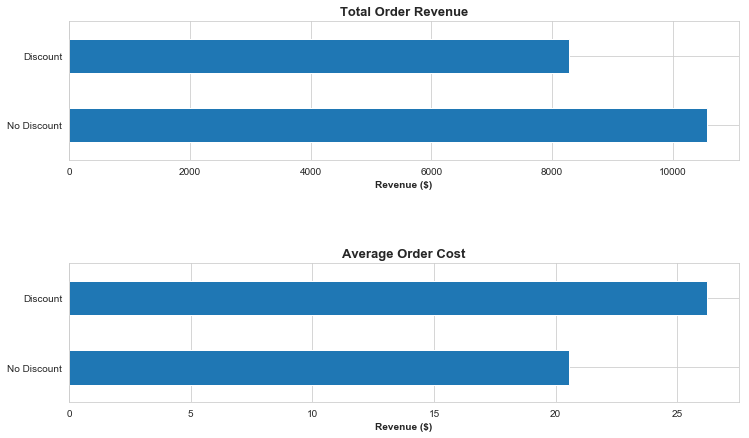

In [55]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(2, 1, figsize=(12,7))
disc_spend.groupby(['DiscBool'])['Quantity'].sum().plot(kind = 'barh', ax = axes[0])
disc_spend.groupby(['DiscBool'])['Quantity'].mean().plot(kind = 'barh', ax = axes[1])
#plot 1:
# Subplot 1 Labels:
axes[0].set_title('Total Order Revenue', fontweight='bold', fontsize=13)
axes[0].set_xlabel('Revenue ($)', fontweight='semibold')
axes[0].set_ylabel('')
axes[0].set_yticklabels(['No Discount', 'Discount'])

#Subplot 2 Labels:
axes[1].set_title('Average Order Cost', fontweight='bold', fontsize=13)
axes[1].set_xlabel('Revenue ($)', fontweight='semibold')
axes[1].set_ylabel('')
axes[1].set_yticklabels(['No Discount', 'Discount'])
fig.subplots_adjust(hspace=.75)


Based on the visualization above, we can see that Northwind earns more total revenue on non-discounted items but the average order cost is higher for discounted items. We will investigate further if these differences are statistically significant.

In [56]:
#separating the dataframe between discounted and non-discounted items:
discounted = disc_spend[disc_spend['Discount']!= 0]
not_discounted = disc_spend[disc_spend['Discount']== 0]
#sanity check
not_discounted.head()

,OrderId,UnitPrice,Discount,Quantity,OrderPrice,DiscBool
0,10248,14.0,0.0,12,440.0,0
1,10249,18.6,0.0,9,1863.4,0
2,10250,7.7,0.0,10,1552.6,0
5,10253,10.0,0.0,20,1444.8,0
7,10255,15.2,0.0,20,2490.5,0


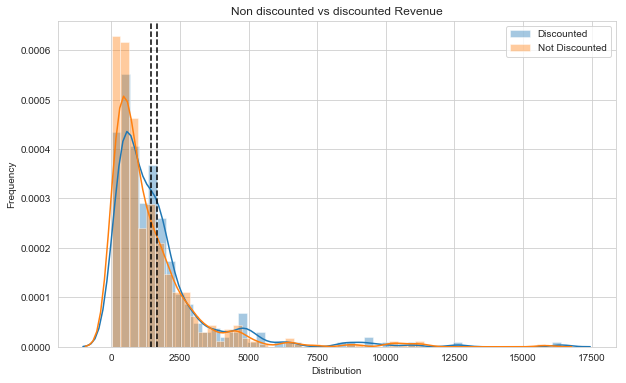

In [57]:
plt.figure(figsize=(10,6))
sns.distplot(discounted.OrderPrice, bins = 50, label = 'Discounted')
sns.distplot(not_discounted.OrderPrice, bins = 50, label = 'Not Discounted')

plt.axvline(discounted.OrderPrice.mean(), color = 'k', linestyle = '--')
plt.axvline(not_discounted.OrderPrice.mean(), color = 'k', linestyle = '--')

plt.title('Non discounted vs discounted Revenue')
plt.xlabel('Distribution')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
#log transform?
log_disc_spend = disc_spend.copy()
log_order_price = np.log(log_disc_spend.OrderPrice)
log_disc_spend['LogOrderPrice'] = log_order_price
log_disc_spend.head(3)

In [ ]:
log_discounted= log_disc_spend[log_disc_spend['Discount'] != 0]
log_nodiscounted = log_disc_spend[log_disc_spend['Discount']== 0]

In [ ]:
#two tailed t-test:
stats.ttest_ind(log_discounted.LogOrderPrice, log_nodiscounted.LogOrderPrice)

As we can see, the p-value is smaller than 0.05 so we  reject the null hypothesis that there is a difference in revenue between discounted and non-discounted items.
No, we can check if there is a statistical difference between the amount of revenue brought in between the different discount levels.

In [ ]:
#visualize prices between different discount amounts:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.boxenplot(data = log_disc_spend, x = discounted.Discount, y = discounted.OrderPrice, palette = 'Set2')
ax = sns.swarmplot(data = log_disc_spend, x = discounted.Discount, y = discounted.OrderPrice, hue = discounted.Discount,
                  palette = 'Set2', alpha = .75)

ax.set_title("Discount vs. Order Revenue", fontweight = 'bold')
ax.set_ylabel('Order Price')
ax.set_ylim(0, 6250)
ax.set_xlabel('Discount Level')
ax.set_xticklabels(['No Discount', '0.05', '0.10', '0.15', '0.20', '0.25'])
ax.legend()

In [ ]:
#new dataframes for the varying discounts
no_discount = log_disc_spend[log_disc_spend.Discount.isin([0])]
disc_5p = log_disc_spend[log_disc_spend.Discount.isin([0.05])]
disc_10p = log_disc_spend[log_disc_spend.Discount.isin([0.10])]
disc_15p = log_disc_spend[log_disc_spend.Discount.isin([0.15])]
disc_20p = log_disc_spend[log_disc_spend.Discount.isin([0.20])]
disc_25p = log_disc_spend[log_disc_spend.Discount.isin([0.25])]

In [ ]:
#viewing the sample sizes:
print(f"Num of order with no discount: {len(no_discount)}")
print(f"Num of orders with 5% discount: {len(disc_5p)}")
print(f"Num of orders with 10% discount: {len(disc_10p)}")
print(f"Num of orders with 15% discount: {len(disc_15p)}")
print(f"Num of orders with 20% discount: {len(disc_20p)}")
print(f"Num of orders with 25% discount: {len(disc_25p)}")

Because the sample sizes are not equal, we can continue with ANOVA/Tukey tests

In [ ]:
#ANOVA:
lm = ols('LogOrderPrice ~ C(Discount)', log_disc_spend).fit()
lm.summary()

In [ ]:
sm.stats.anova_lm(lm, typ = 2)

In [ ]:
tk2 = pairwise_tukeyhsd(log_disc_spend.LogOrderPrice, log_disc_spend.Discount, .05)
print(tk2)

In [ ]:
#effect size:
d = cohen_d(no_discount.LogOrderPrice, disc_5p.LogOrderPrice)
print(d)

The results above show us that there is a statistically significance in order revenue between the following discount levels:
    - 0 and 5%
 Between the discount levels, we can see that there is no statistically significance and we fail to reject the null hypothesis, which lends credence to the fact that discounts are lowering profits.

## Question 3

##  Do discounts affect the quantity sold for certain products?

- $H_0$: The average quantity ordered is the same for all discount levels <br>
- $H_a$: The average quantity ordered is different for different discount levels <br>
- $alpha$ = 0.05

In [9]:
c.execute('''SELECT c.Id, c.CategoryName, p.ProductName, od.Discount, od.Quantity FROM Product p
            INNER JOIN OrderDetail od on od.ProductId = p.Id
            INNER JOIN Category c on p.CategoryId = c.Id''')
category_spend = pd.DataFrame(c.fetchall())
category_spend.columns = [column[0] for column in c.description]
category_spend.head()

,Id,CategoryName,ProductName,Discount,Quantity
0,4,Dairy Products,Queso Cabrales,0.0,12
1,5,Grains/Cereals,Singaporean Hokkien Fried Mee,0.0,10
2,4,Dairy Products,Mozzarella di Giovanni,0.0,5
3,7,Produce,Tofu,0.0,9
4,7,Produce,Manjimup Dried Apples,0.0,40


In [10]:
category_spend.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 5 columns):
Id              2155 non-null int64
CategoryName    2155 non-null object
ProductName     2155 non-null object
Discount        2155 non-null float64
Quantity        2155 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 84.3+ KB


In [11]:
#how many categories of each
print(len(category_spend.Id.unique()))
print(category_spend.CategoryName.value_counts())

8
Beverages         404
Dairy Products    366
Confections       334
Seafood           330
Condiments        216
Grains/Cereals    196
Meat/Poultry      173
Produce           136
Name: CategoryName, dtype: int64


In [12]:
values = [0.00, 0.05, 0.10, 0.15, 0.20, 0.25]
category_spend = category_spend[category_spend.Discount.isin(values)]

In [13]:
cats = [1, 2, 3, 4, 5, 6, 7, 8]
cat_quantity = pd.DataFrame([])
for i in cats:
    c = category_spend[category_spend.Id == i]
    disc = c[c['Discount']!= 0]
    nodisc = c[c['Discount'] == 0]
    results = stats.ttest_ind(disc.Quantity, nodisc.Quantity, equal_var = False)
    cat_quantity = cat_quantity.append(pd.DataFrame({'Category': category_spend.CategoryName[i],
                                                    'Stat': round(results[0], 3),
                                                    'P-value': round(results[1], 3)},
                                                    index = [0]), ignore_index = None)
cat_quantity

,Category,Stat,P-value
0,Grains/Cereals,3.484,0.001
0,Dairy Products,2.851,0.005
0,Produce,0.947,0.344
0,Produce,3.638,0.000
0,Seafood,0.726,0.469
0,Produce,2.343,0.021
0,Condiments,0.972,0.335
0,Grains/Cereals,2.349,0.020


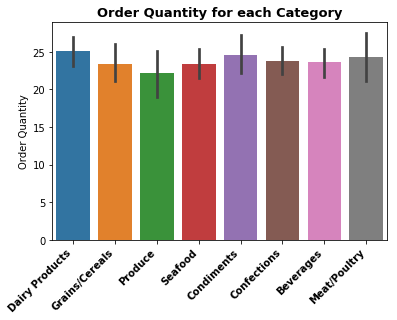

In [14]:
sns.set_color_codes = 'Set2'
fig,ax = plt.subplots()
sns.barplot(x = category_spend.CategoryName, y = category_spend.Quantity)
ax.set_title('Order Quantity for each Category', fontweight = 'bold', fontsize = 13)
ax.set_xlabel('')
ax.set_ylabel('Order Quantity')
plt.xticks(rotation = 45, ha = 'right', fontweight = 'semibold')
plt.show()
fig.savefig('categories_quantity', bbox_inches = 'tight')

From above, we can see that grains/cereals, dairy products and produce have p-values < 0.05, so can reject the null hypothesis for those categories. In those cases, that the discounts increase average order quantity by 3.5, 2.7, 2.3 respectively.

In [51]:
c.execute('''SELECT * FROM ''')
cat = pd.DataFrame(c.fetchall())
cat.columns = [column[0] for column in c.description]
cat.head()

,Id,CategoryName,Description
0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,2,Condiments,"Sweet and savory sauces, relishes, spreads, an..."
2,3,Confections,"Desserts, candies, and sweet breads"
3,4,Dairy Products,Cheeses
4,5,Grains/Cereals,"Breads, crackers, pasta, and cereal"


In [ ]:
#Visualizing the distribution
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(12, 5))
ax = sns.boxenplot(data = category_spend, x = category_spend.CategoryName, y = category_spend.Quantity, palette = 'Set2')
ax = sns.swarmplot(data = category_spend, x = category_spend.CategoryName, y = category_spend.Quantity, 
                    hue = category_spend.Discount, palette = 'Set2')
ax.set_title('Discount vs. Order Quantity', fontweight = 'bold', fontsize = 13)
ax.set_ylabel('Order Quantity')
ax.set_xlabel('')
ax.set_ylim(0)
plt.xticks(rotation = 45, ha = 'right')
plt.show()

## Question 4

## Does the demand for produce change throughout the year?

- $H_0$: There is no statistical difference in the demand of produce each month <br>
- $H_a$: There is a statistical difference in the demand of produce each month <br>
- $alpha$ = 0.05 <br>

In [4]:
c.execute('''SELECT o.OrderDate, od.Quantity, od.Discount, CategoryId FROM [Order] as o
            JOIN OrderDetail as od on o.Id = od.OrderId
            JOIN Product as p on p.Id = od.ProductId
            WHERE P.CategoryId = 7''')
produce_demand = pd.DataFrame(c.fetchall())
produce_demand.columns = [column[0] for column in c.description]
produce_demand.head()

,OrderDate,Quantity,Discount,CategoryId
0,2012-07-05,9,0.00,7
1,2012-07-05,40,0.00,7
2,2012-07-08,35,0.15,7
3,2012-07-11,21,0.00,7
4,2012-07-22,15,0.00,7


In [5]:
produce_demand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 4 columns):
OrderDate     136 non-null object
Quantity      136 non-null int64
Discount      136 non-null float64
CategoryId    136 non-null int64
dtypes: float64(1), int64(2), object(1)
memory usage: 4.3+ KB


In [6]:
#Group by Month:
produce_demand.OrderDate = pd.to_datetime(produce_demand.OrderDate)
produce_demand['Month'] = produce_demand.OrderDate.dt.month

In [7]:
produce_demand.groupby('Month').mean()

,Quantity,Discount,CategoryId
Month,,,
1,16.545455,0.050000,7.0
2,15.555556,0.011111,7.0
3,21.500000,0.004545,7.0
4,29.105263,0.028947,7.0
5,12.888889,0.075556,7.0
6,21.285714,0.085714,7.0
7,26.375000,0.050000,7.0
8,15.666667,0.038889,7.0
9,17.500000,0.025000,7.0


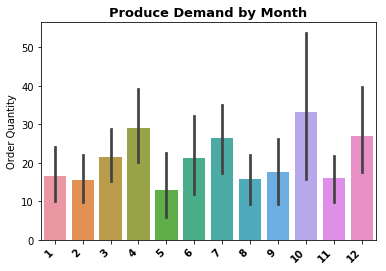

In [8]:
sns.set_color_codes = 'Set2'
fig,ax = plt.subplots()
sns.barplot(x = produce_demand.Month, y = produce_demand.Quantity)
ax.set_title('Produce Demand by Month', fontweight = 'bold', fontsize = 13)
ax.set_xlabel('')
ax.set_ylabel('Order Quantity')
plt.xticks(rotation = 45, ha = 'right', fontweight = 'semibold')
plt.show()
fig.savefig('producedemand.png', bbox_inches = 'tight')

The graph above shows that there is a slight difference for the demand for produce every month. For example, there seems to be a huge difference in demand for produce in October compared to other months. We will investigate if this difference is statistically significant.

In [ ]:
#ANOVA 
formula = 'Quantity ~ C(Month)'
lm = ols(formula, produce_demand).fit()
table = sm.stats.anova_lm(lm, typ = 2)
print(table)

From the ANOVA test, we can see that our p-value > 0.05, so we fail to reject the null hypothesis and say that the demand for produce is the same throughout the year.

## Question 5

## Is there difference between employee performance in the US and the UK?

- $H_0$ : Employees perform at the same level regardless of employment <br>
- $H_a$ : There is a  difference between the performance of the performance in the US and the UK employees <br>
- $alpha$ = 0.05 <br>

There is are several ways to measure employee performance which includes:
- customer survey <br>
- number of orders processed by each employee <br>
- time it took to process each order <br>
First, let's explore number of orders

In [32]:
c.execute('''SELECT o.EmployeeId, e.Country, count(o.Id) as Total_Orders FROM [Order] as o 
        JOIN Employee as e on o.EmployeeId = e.Id
        GROUP BY e.Id''')
employee_orders = pd.DataFrame(c.fetchall())
employee_orders.columns = [column[0] for column in c.description]
employee_orders.head()

,EmployeeId,Country,Total_Orders
0,1,USA,123
1,2,USA,96
2,3,USA,127
3,4,USA,156
4,5,UK,42


In [33]:
employee_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 3 columns):
EmployeeId      9 non-null int64
Country         9 non-null object
Total_Orders    9 non-null int64
dtypes: int64(2), object(1)
memory usage: 296.0+ bytes


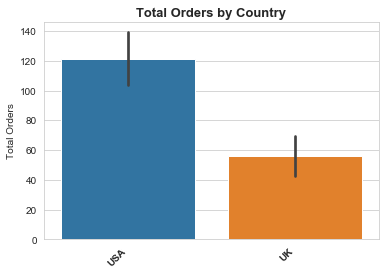

<Figure size 432x288 with 0 Axes>

In [59]:
sns.set_color_codes = 'Set2'
fig,ax = plt.subplots()
sns.barplot(x = employee_orders.Country, y = employee_orders.Total_Orders)
ax.set_title('Total Orders by Country', fontweight = 'bold', fontsize = 13)
ax.set_xlabel('')
ax.set_ylabel('Total Orders')
plt.xticks(rotation = 45, ha = 'right', fontweight = 'semibold')
plt.show()
plt.savefig('employee_orders', bbox_inches = 'tight')

As we can from above there is a clear difference between the number of orders from the USA compared to the UK. Now we will investigate if this difference is statistically significant.

In [ ]:
#ANOVA test
formula = 'Total_Orders ~ C(Country)'
lm = ols(formula, employee_orders).fit()
table = sm.stats.anova_lm(lm, typ = 2)
print(table)

In [ ]:
#Cohen's d function
usa = employee_orders.Country == 'USA'
uk = employee_orders.Country == 'UK'
d = cohen_d(usa, uk)
print("Cohen's d: ", d)

From the ANOVA test, the p-value is less than 0.05 and we can reject the null hypothesis. However, looking at the effect size of that difference is only about 0.21, which is a small effect. It is possible that because the United States is the bigger country it's employees are able to cover more ground. Now,  we shall see if there is a difference between the time orders are processed.

### Time orders are processed between US employees vs UK employees?

In [ ]:
order_time = pd.read_sql_query("""SELECT o.Id, o.OrderDate, o.ShippedDate, e.Country FROM [Order] as o
                            JOIN [Employee] as e on o.EmployeeId = e.Id""", engine)

In [38]:
c.execute('''SELECT o.Id, o.OrderDate, o.ShippedDate, e.Country FROM [Order] as o
            JOIN Employee as e on o.EmployeeId = e.Id''')
order_time = pd.DataFrame(c.fetchall())
order_time.columns = [column[0] for column in c.description]

In [39]:
order_time.head()

,Id,OrderDate,ShippedDate,Country
0,10248,2012-07-04,2012-07-16,UK
1,10249,2012-07-05,2012-07-10,UK
2,10250,2012-07-08,2012-07-12,USA
3,10251,2012-07-08,2012-07-15,USA
4,10252,2012-07-09,2012-07-11,USA


In [40]:
order_time.OrderDate = pd.to_datetime(order_time.OrderDate)
order_time.ShippedDate = pd.to_datetime(order_time.ShippedDate)
order_time['ProcessingTime'] = (order_time.ShippedDate - order_time.OrderDate).dt.days
#print(order_time.dt.days)
order_time.head()

,Id,OrderDate,ShippedDate,Country,ProcessingTime
0,10248,2012-07-04,2012-07-16,UK,12.0
1,10249,2012-07-05,2012-07-10,UK,5.0
2,10250,2012-07-08,2012-07-12,USA,4.0
3,10251,2012-07-08,2012-07-15,USA,7.0
4,10252,2012-07-09,2012-07-11,USA,2.0


In [41]:
order_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 5 columns):
Id                830 non-null int64
OrderDate         830 non-null datetime64[ns]
ShippedDate       809 non-null datetime64[ns]
Country           830 non-null object
ProcessingTime    809 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(1), object(1)
memory usage: 32.5+ KB


In [42]:
order_time.dropna(inplace = True)
order_time.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 809 entries, 0 to 821
Data columns (total 5 columns):
Id                809 non-null int64
OrderDate         809 non-null datetime64[ns]
ShippedDate       809 non-null datetime64[ns]
Country           809 non-null object
ProcessingTime    809 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(1), object(1)
memory usage: 37.9+ KB


In [43]:
usa = order_time[order_time.Country == 'USA']['ProcessingTime']
uk = order_time[order_time.Country == 'UK']['ProcessingTime']
print(usa.mean(), uk.mean())
print(stats.ttest_ind(usa, uk)) # two tailed Welch's t-test

8.375634517766498 8.807339449541285
Ttest_indResult(statistic=-0.7964601243449388, pvalue=0.42599888071882475)


Because the p-value is greater than 0.05, we fail to reject the null hypothesis and can say that there is no difference between the time orders are processed between US and UK employees. In order to investigate if the amount revenue each employee brings in, we would need more metrics than are avaiable to us like employee salary to make revenue analysis meaningful.

### Question 6

### Relationship between freight costs and the different shipping companies?

- $H_0$: The average freight cost is the same among all the shippers
- $H_a$: The average freight cost is different among the different shippers
- $alpha$ = 0.05

In [17]:
c.execute('''SELECT Id , ShipVia, Freight, ShipRegion, RequiredDate, ShippedDate, OrderDate  FROM [Order];''')
df_freight = pd.DataFrame(c.fetchall())
df_freight.columns = [column[0] for column in c.description]
df_freight.head()

,Id,ShipVia,Freight,ShipRegion,RequiredDate,ShippedDate,OrderDate
0,10248,3,32.38,Western Europe,2012-08-01,2012-07-16,2012-07-04
1,10249,1,11.61,Western Europe,2012-08-16,2012-07-10,2012-07-05
2,10250,2,65.83,South America,2012-08-05,2012-07-12,2012-07-08
3,10251,1,41.34,Western Europe,2012-08-05,2012-07-15,2012-07-08
4,10252,2,51.30,Western Europe,2012-08-06,2012-07-11,2012-07-09


In [18]:
c.execute("""SELECT * FROM Shipper""")
shipper_df = pd.DataFrame(c.fetchall())
shipper_df.columns = [column[0] for column in c.description]
shipper_df

,Id,CompanyName,Phone
0,1,Speedy Express,(503) 555-9831
1,2,United Package,(503) 555-3199
2,3,Federal Shipping,(503) 555-9931


In [19]:
df_freight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 7 columns):
Id              830 non-null int64
ShipVia         830 non-null int64
Freight         830 non-null float64
ShipRegion      830 non-null object
RequiredDate    830 non-null object
ShippedDate     809 non-null object
OrderDate       830 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 45.5+ KB


In [20]:
df_freight.ShipVia.value_counts()

2    326
3    255
1    249
Name: ShipVia, dtype: int64

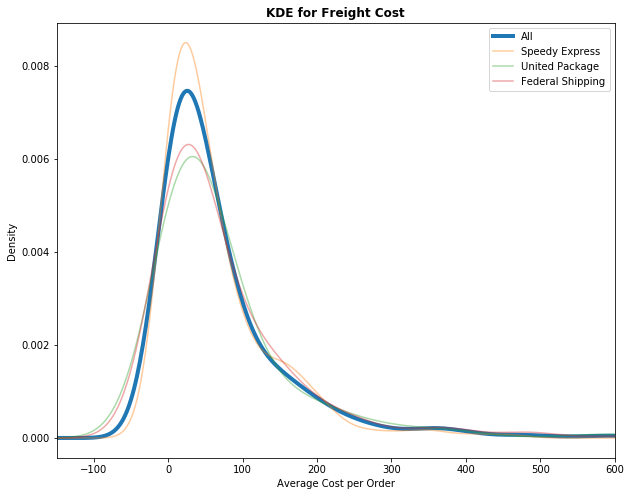

In [21]:
shippers = pd.DataFrame([])
plt.figure(figsize=(10, 8))
df_freight.Freight.plot.kde(label = 'All', linewidth = 4)
for i in [1,2,3]:
    x = df_freight[df_freight['ShipVia'] == i]
    y = df_freight[df_freight['ShipVia'] != i]
    x.Freight.plot.kde(label = shipper_df.CompanyName[i-1], alpha = .4)
    results = stats.ttest_ind(x.Freight, y.Freight, equal_var = False)
    shippers = shippers.append(pd.DataFrame({'Shipper': shipper_df.CompanyName[i-1], 'Coeffiecient': round(results[0], 3),
                                            'P-value': round(results[1], 3)}, index = [0]), ignore_index = True)
plt.title('KDE for Freight Cost', fontweight = 'bold')
plt.xlabel('Average Cost per Order')
plt.legend()
plt.xlim(-150, 600)
plt.show()

In [22]:
shippers

,Shipper,Coeffiecient,P-value
0,Speedy Express,-2.623,0.009
1,United Package,1.560,0.119
2,Federal Shipping,0.356,0.722


Based on the above, Shipper Express has a p-value < 0.05 and thus the results are statitstically significance. However this is misleading because there are several variables that are unknown to us. Lets explore the same analysis for each region that products are shipped to.

In [23]:
Regions=['Western Europe','North America','Southern Europe',
         'British Isles','Scandinavia','Victoria',
         'Northern Europe','Eastern Asia','NSW',
         'South-East Asia','South America']
for i in Regions:
    shipper_region = pd.DataFrame([])
    reg = df_freight[df_freight['ShipRegion']==i]
    count = 0
    for j in [1,2,3]:
        x = reg[reg['ShipVia']==j]
        y = reg[reg['ShipVia']!= j]
        if x.shape[0] > 1 and y.shape[0] > 1:
            count+= 1
            results = stats.ttest_ind(x.Freight, y.Freight, equal_var = False)
            shipper_region = shipper_region.append(pd.DataFrame({'Shipper': shipper_df.CompanyName[j-1],
                                                                'Coefficient': round(results[0], 3),
                                                                'P-value': round(results[1], 3)},index=[0]), ignore_index = True)
        else:
            None
    if count == 3:
        print(i)
        print(shipper_region)
        print('')

Western Europe
            Shipper  Coefficient  P-value
0    Speedy Express       -0.566    0.572
1    United Package       -0.862    0.390
2  Federal Shipping        1.352    0.179

North America
            Shipper  Coefficient  P-value
0    Speedy Express       -2.100    0.038
1    United Package        0.443    0.659
2  Federal Shipping        0.735    0.464

Southern Europe
            Shipper  Coefficient  P-value
0    Speedy Express       -1.380    0.173
1    United Package        1.574    0.127
2  Federal Shipping       -0.576    0.568

British Isles
            Shipper  Coefficient  P-value
0    Speedy Express       -0.557    0.580
1    United Package        1.327    0.192
2  Federal Shipping       -1.365    0.176

Scandinavia
            Shipper  Coefficient  P-value
0    Speedy Express       -0.771    0.451
1    United Package        1.757    0.109
2  Federal Shipping       -1.568    0.130

Northern Europe
            Shipper  Coefficient  P-value
0    Speedy Express       

We find that it is cheaper for Shipper Express to ship to North America and for United Package to ship to Northern Europe. Now we shall if there is a difference in how days it takes to ship products.

In [24]:
df_freight.head()

,Id,ShipVia,Freight,ShipRegion,RequiredDate,ShippedDate,OrderDate
0,10248,3,32.38,Western Europe,2012-08-01,2012-07-16,2012-07-04
1,10249,1,11.61,Western Europe,2012-08-16,2012-07-10,2012-07-05
2,10250,2,65.83,South America,2012-08-05,2012-07-12,2012-07-08
3,10251,1,41.34,Western Europe,2012-08-05,2012-07-15,2012-07-08
4,10252,2,51.30,Western Europe,2012-08-06,2012-07-11,2012-07-09


In [25]:
#convert datetimes:
df_freight['RequiredDate'] = pd.to_datetime(df_freight['RequiredDate'])
df_freight['ShippedDate'] = pd.to_datetime(df_freight['ShippedDate'])
df_freight['OrderDate'] = pd.to_datetime(df_freight['OrderDate'])

In [26]:
#making new columns
df_freight['DaystoShip'] = df_freight['ShippedDate'] - df_freight['OrderDate']
df_freight['DaysLate'] = df_freight['ShippedDate'] - df_freight['RequiredDate']

In [27]:
df_freight.DaystoShip.mean()

Timedelta('8 days 11:48:25.809641')

In [28]:
shipvia1 = df_freight[df_freight['ShipVia'] == 1]['Freight']
shipvia2 = df_freight[df_freight['ShipVia'] == 2]['Freight']
shipvia3 = df_freight[df_freight['ShipVia'] == 3]['Freight']

In [29]:
#averages of shipvias:
print(shipvia1.mean())
print(shipvia2.mean())
print(shipvia3.mean())

65.00132530120482
86.6406441717791
80.44121568627443


In [30]:
#ANOVA test:
sp.stats.f_oneway(shipvia1, shipvia2, shipvia3)

F_onewayResult(statistic=2.49781040377206, pvalue=0.08288539205995446)

Because the p-value > 0.05, we fail to reject the null hypothesis. So there isn't a statistical difference effect on ShipVia on the number of days to ship. I would recommend that Northwind keep using the 3 ShipVias because there is no difference between their days to ship.

In [ ]:
cohen_d(shipvia1, shipvia2)

In [ ]:
cohen_d(shipvia1, shipvia3)

In [ ]:
cohen_d(shipvia2, shipvia3)

Small effect sizes but interesting to know.

## 5. Conclusions

1: Do discounts have a statistically significant difference on the number of products orders? <br>
     Discounts will cause an increase in the quantity of products ordered but the level of discount doesn't have an effect. <br>
2: Do discounts affect revenues? <br>
     Discounts do affect revenues but not at any specfic discount level <br>
3: Do discounts affect the order quantities of certain product categories? <br>
    The average order quantity increased for produce, dairy products and condiments <br>
4: Is there a difference in employee performance between US and UK employees? <br>
    US employees have a higher order number than UK employees but both US and UK employees process orders at the same rate <br>
5: What is the relationship between freight costs and the different shipping companies <br>
    Add in the answer here <br>

## 6. Future Works